# Fire Detection in Images

**Description about the dataset:**

Data was collected to train a model to distinguish between the images that contain fire (fire images) and regular images (non-fire images). Data is divided into 2 folders, fireimages folder contains 755 outdoor-fire images some of them contains heavy smoke, the other one is non-fireimages which contain 244 nature images (eg: forest, tree, grass, river, people, foggy forest, lake, animal, road, and waterfall).

**Objective: To create a classification model that can detect fire in images**

**Models used: Sequential CNN from scratch, Pretrained Xception with modifications**

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

sns.set_style('darkgrid')

**Let's first create a dataframe that contains the path to each picture and its corresponding label (fire or non fire).**

**Reading Paths**

In [25]:
import os
import pandas as pd

# Create an empty list to store data
data = []

# Loop over fire images and label them as 'fire'
fire_images_path = r"D:\\B-tech\\5th\\Ml final project report\\Detecting fire in image\\Image Dataset\\fire_dataset\\fire_images"
for dirname, _, filenames in os.walk(fire_images_path):
    for filename in filenames:
        data.append([os.path.join(dirname, filename), 'fire'])

# Loop over non-fire images and label them as 'non_fire'
non_fire_images_path = r"D:\\B-tech\\5th\\Ml final project report\\Detecting fire in image\\Image Dataset\\fire_dataset\\non_fire_images"
for dirname, _, filenames in os.walk(non_fire_images_path):
    for filename in filenames:
        data.append([os.path.join(dirname, filename), 'non_fire'])

# Convert list to DataFrame
df = pd.DataFrame(data, columns=['path', 'label'])

# Shuffle the dataset to redistribute the labels
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display first 10 rows
print(df.head(10))



                                                path     label
0  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire
1  D:\\B-tech\\5th\\Ml final project report\\Dete...  non_fire
2  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire
3  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire
4  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire
5  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire
6  D:\\B-tech\\5th\\Ml final project report\\Dete...  non_fire
7  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire
8  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire
9  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire


**Great! the dataset has been created. Let's see how well the data is shuffled.**

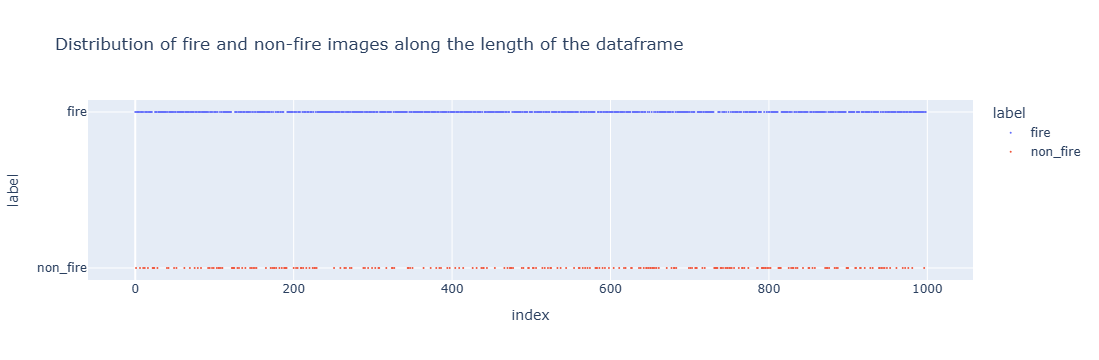

In [27]:
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

**The shuffling has taken place well.**

**Let's visualize the countplot of the data**

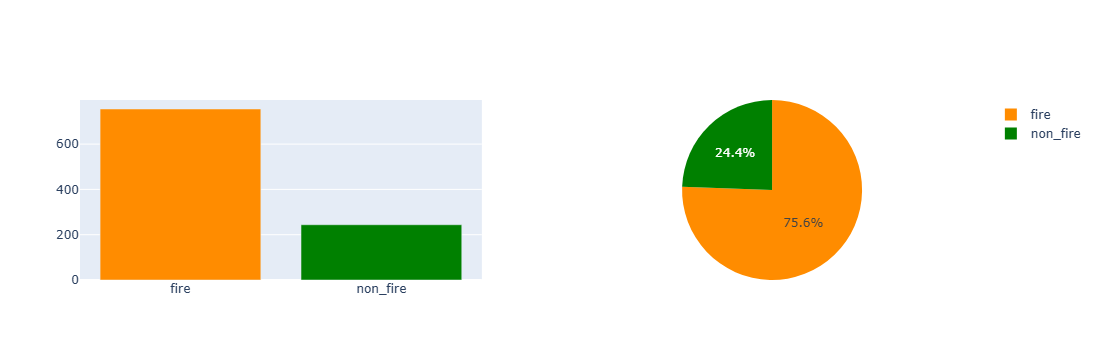

In [29]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)


**Non fire label has less number of images. The dataset is imbalanced**

## Visualizing the images with fire

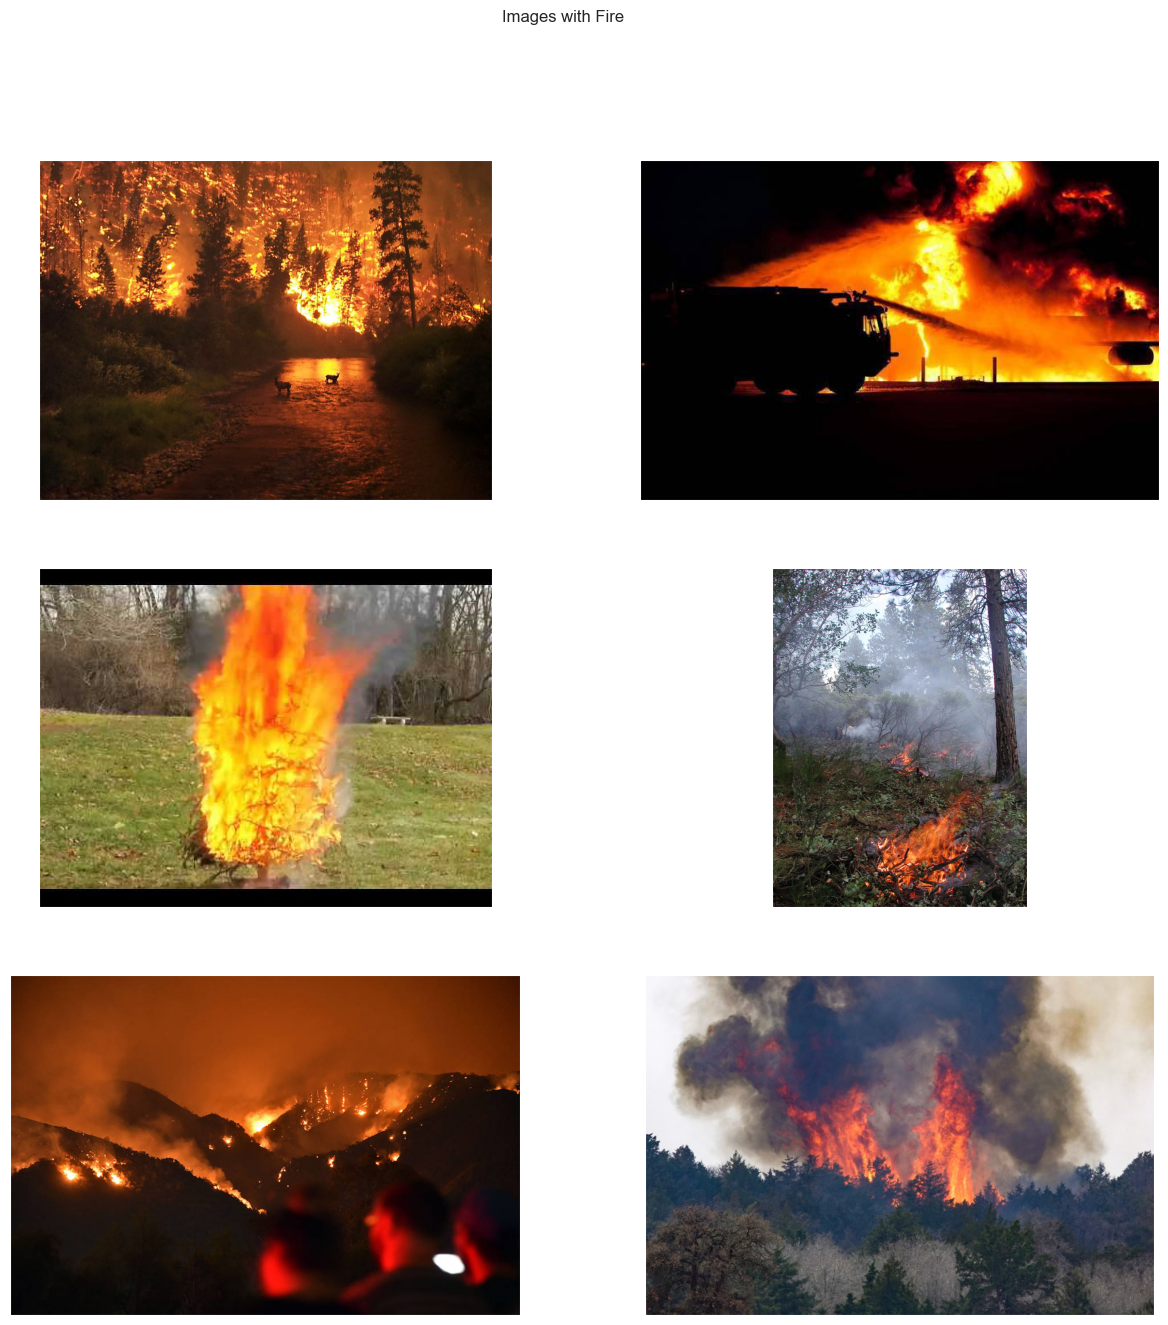

In [31]:
label = 'fire' #label for images with fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

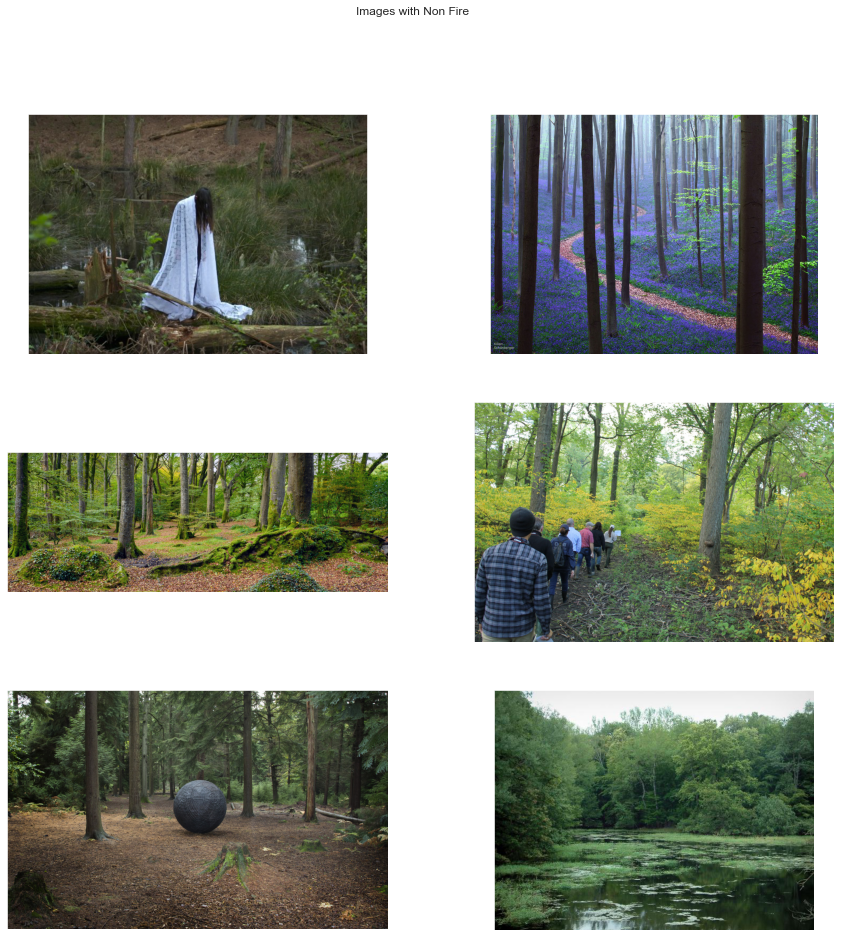

In [6]:
label = 'non_fire' #label for images without fire
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Non Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

**As you can see, the sizes of the images are different. Let's visualize the distribution of their shapes**

In [33]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

path     label  height  width
0  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire     405    720
1  D:\\B-tech\\5th\\Ml final project report\\Dete...  non_fire     410    618
2  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire     305    458
3  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire     600    901
4  D:\\B-tech\\5th\\Ml final project report\\Dete...      fire     400    600

## Visualizing Shape Distribution

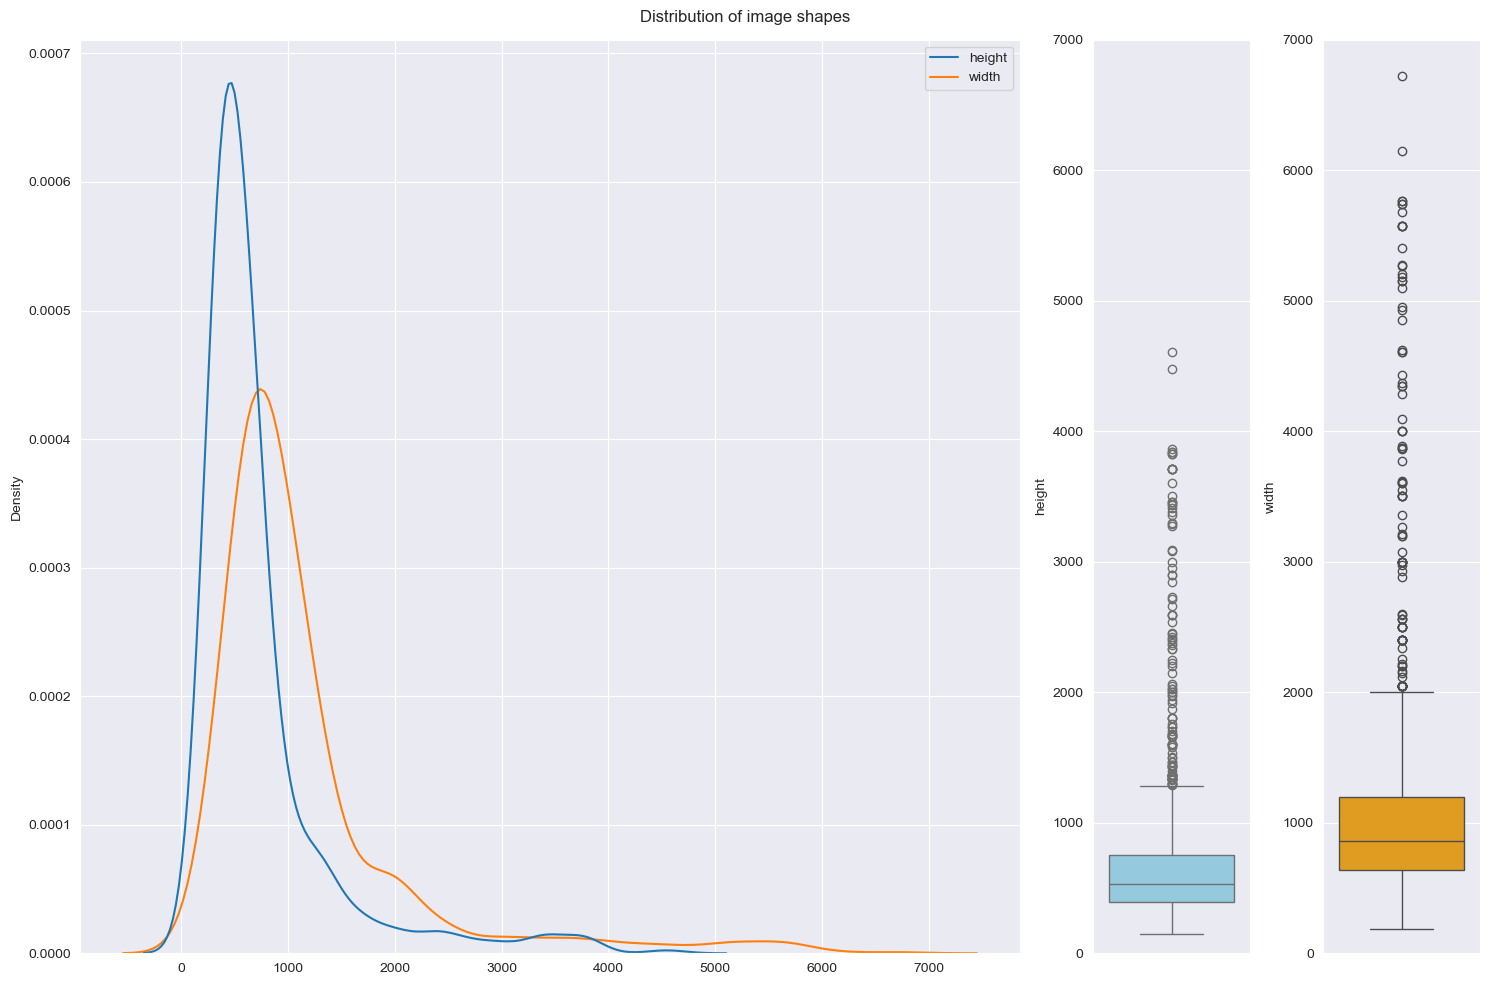

In [35]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

**The height and width of images vary too much. We have to reshape them to a fixed shape before training**

## Image Generation or Augmentation

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

**Creating the training and test generator**

**We will use the flow_from_dataframe method of the ImageDataGenerator class. It will take the path of the images from the dataframe along with their labels. We construct two generators, one for training and the other for validation.**

**Note: Our labels are strings 'fire ' and 'non_fire'. Image generator will automatically encode them to integer labels.**

In [43]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='training')
val_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',subset='validation')

Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


#### Class indices assigned by the Image generator

In [45]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


**Hence an image predicted 0 will contain fire and 1 won't.**

## Visualizing the generated images in training set

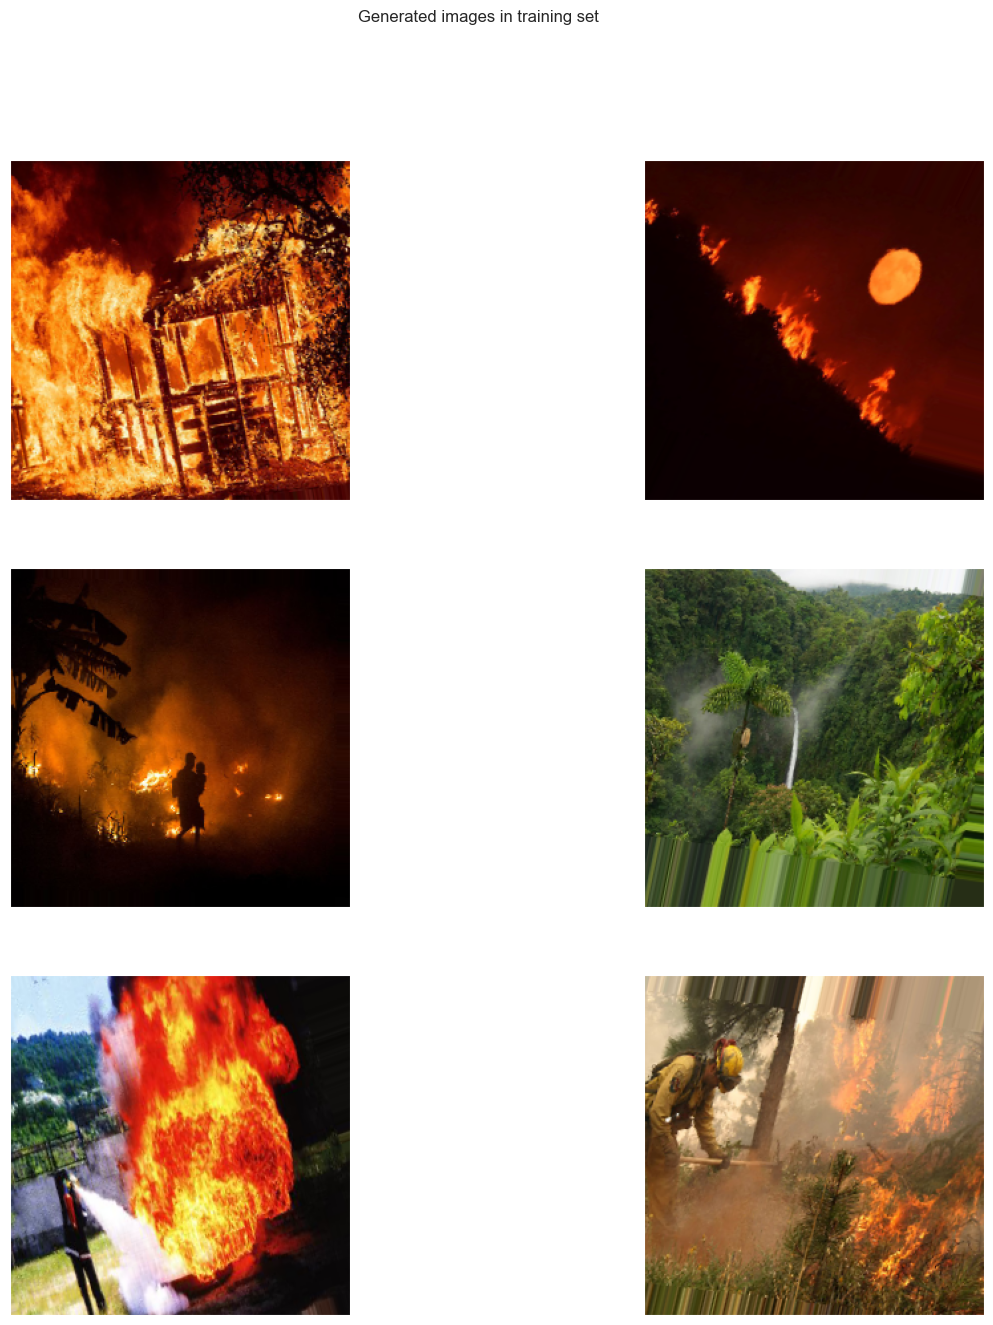

In [47]:
sns.set_style('dark')
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

# CNN

# Creating the model

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense

In [59]:

model = Sequential([
    Input(shape=(256, 256, 3)),  # ✅ Define input shape here
    Conv2D(filters=32, kernel_size=(2,2), activation='relu'),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=(2,2), activation='relu'),
    MaxPool2D(),
    Conv2D(filters=128, kernel_size=(2,2), activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 255, 255, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 62, 62, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,916,257 (30.20 MB)

 Trainable params: 7,916,257 (30.20 MB)

 Non-trainable params: 0 (0.00 B)

**We increase the number of filters as we add more layers because initially there will be a lot of noise present in the input and we only need to capture the important information. Later as we progress through the layers, the feature maps become nuanced and we try to capture them with more filters**  

### Model Summary

In [61]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 255, 255, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 62, 62, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,916,257 (30.20 MB)

 Trainable params: 7,916,257 (30.20 MB)

 Non-trainable params: 0 (0.00 B)

**Compiling the model**

In [63]:
from tensorflow.keras.metrics import Recall,AUC
from tensorflow.keras.utils import plot_model

In [65]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

**Defining Callbacks**


In [67]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [69]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

### Model Fitting

In [73]:
model.fit(train_gen, epochs=5, validation_data=val_gen, callbacks=[early_stoppping, reduce_lr_on_plateau])


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9602 - auc: 0.9912 - loss: 0.0989 - recall: 0.9235 - val_accuracy: 0.9648 - val_auc: 0.9944 - val_loss: 0.0925 - val_recall: 0.9423 - learning_rate: 0.0010
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9545 - auc: 0.9892 - loss: 0.1136 - recall: 0.8908 - val_accuracy: 0.9497 - val_auc: 0.9806 - val_loss: 0.1807 - val_recall: 0.8077 - learning_rate: 0.0010
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9582 - auc: 0.9884 - loss: 0.1007 - recall: 0.9224 - val_accuracy: 0.9548 - val_auc: 0.9942 - val_loss: 0.1475 - val_recall: 0.8269 - learning_rate: 0.0010
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9571 - auc: 0.9922 - loss: 0.1093 - recall: 0.8871 - val_accuracy: 0.9749 - val_auc: 0.9849 - val_loss: 0.1020 - val_recall: 0.9231 - learning_rate: 0.0010
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9833 - auc: 0.9934 - loss: 0.0628 - recall: 0.9599 - val_accu

### Model Evaluation

**Plotting metrics**

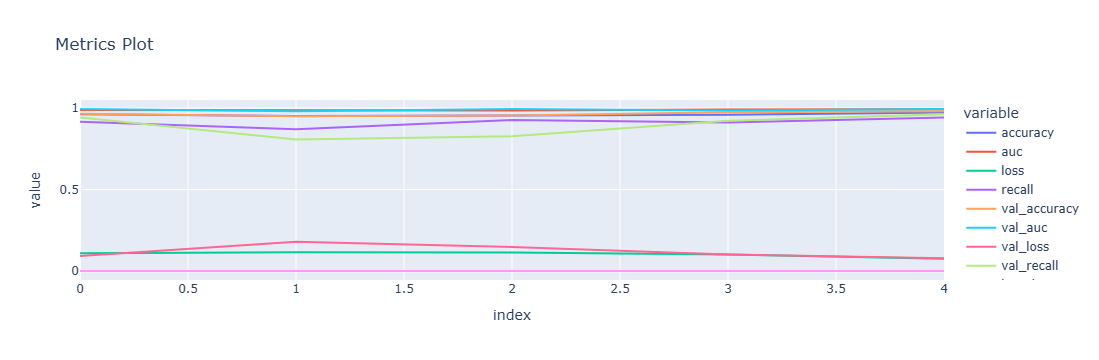

In [75]:
history= model.history.history
px.line(history,title = "Metrics Plot")

In [77]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 984ms/step - accuracy: 0.9637 - auc: 0.9873 - loss: 0.1013 - recall: 0.9020
accuracy: 0.97
auc: 0.99
loss: 0.08
recall: 0.92


## Model creation by transfer learning

In [79]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [81]:
xception = Xception(include_top = False,input_shape = (256,256,3))
input_to_model = xception.input
#turn off training
xception.trainable = False

x = Flatten()(xception.output)
x = Dense(64,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model2 = Model(inputs = input_to_model,outputs = output_to_model)

**Compiling the model**

In [83]:
model2.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy',Recall(),AUC()])

**Fitting the model**

In [86]:
history2 = model2.fit(x = train_gen,batch_size=32,epochs=5,callbacks = [early_stoppping,reduce_lr_on_plateau],validation_data = val_gen)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.8402 - auc_1: 0.8388 - loss: 1.8938 - recall_1: 0.6910 - val_accuracy: 0.9397 - val_auc_1: 0.9382 - val_loss: 0.5618 - val_recall_1: 0.8077 - learning_rate: 0.0010
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.9658 - auc_1: 0.9922 - loss: 0.1192 - recall_1: 0.9374 - val_accuracy: 0.9397 - val_auc_1: 0.9576 - val_loss: 0.2719 - val_recall_1: 0.9231 - learning_rate: 0.0010
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.9772 - auc_1: 0.9935 - loss: 0.0716 - recall_1: 0.9726 - val_accuracy: 0.9548 - val_auc_1: 0.9588 - val_loss: 0.2640 - val_recall_1: 0.8462 - learning_rate: 0.0010
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.9846 - auc_1: 0.9981 - loss: 0.0397 - recall_1: 0.9566 - val_accuracy: 0.9447 - val_auc_1: 0.9853 - val_loss: 0.2367 - val_recall_1: 0.9423 - learning_rate: 0.0010
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - accuracy: 0.9792 - auc_1: 0.9983 - l

### Model Evaluation

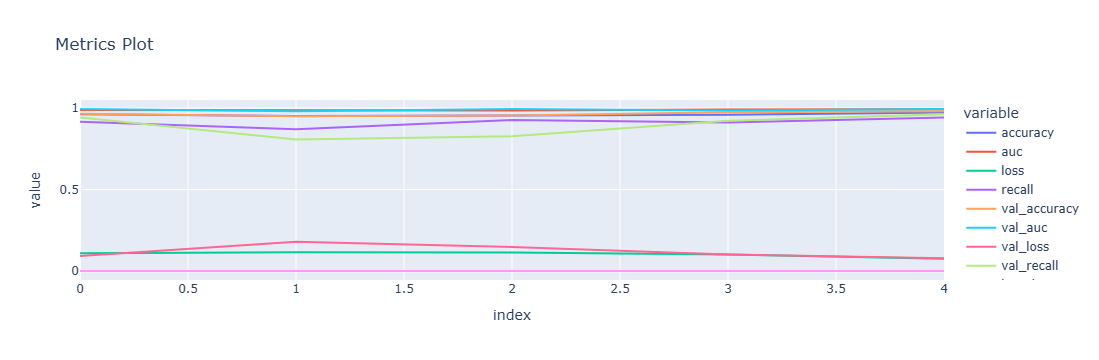

In [88]:
px.line(history,title='Metrics Plot')

In [90]:
eval_list = model.evaluate(val_gen,return_dict=True)
for metric in eval_list.keys():
    print(metric+f": {eval_list[metric]:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9805 - auc: 0.9964 - loss: 0.0692 - recall: 0.9717
accuracy: 0.98
auc: 1.00
loss: 0.07
recall: 0.96


## Example Prediction

**Let's use an image of the apartment complex in Texas that caught fire in February 2021.**

News link : https://www.nytimes.com/2021/02/19/us/san-antonio-fire-hydrants-water.html

In [92]:
#Downloading the image
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 50241  100 50241    0     0  73350      0 --:--:-- --:--:-- --:--:-- 73559


**Printing the image**

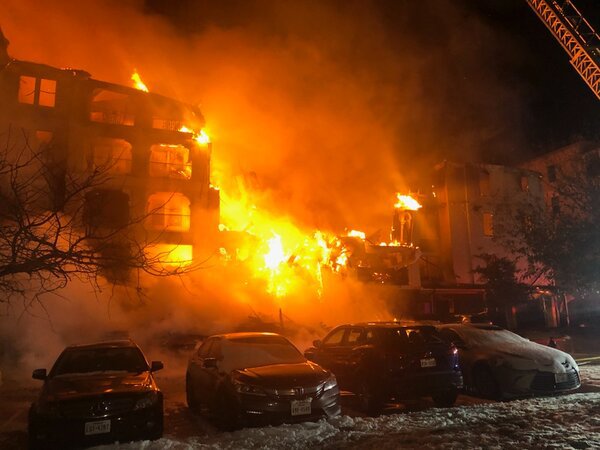

In [94]:
#loading the image
img = image.load_img('predict.jpg')
img

**Resizing the image and expanding its dimension to include the batch size - 1**

In [96]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 256, 256, 3)


**Prediction**

In [98]:
prediction = int(tf.round(model2.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted value is:  0 and the predicted label is: fire


# Thank You